<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/4_GRU_Multivariate_Horizon_Style_FlowData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [157]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
#                infer_datetime_format=True)

url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



In [158]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [159]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [160]:
#df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [161]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [162]:
#df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

df = df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [163]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [164]:
#validate = df[['avg_tcp_window_size','std_dev_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
validate = df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(250)

df.drop(df.tail(250).index,inplace=True)
#original
#validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(200)
#df.drop(df.tail(200).index,inplace=True)

In [165]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
#dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataX = x_scaler.fit_transform(df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [166]:
hist_window = 100
#original
#hist_window = 80
horizon = 250
TRAIN_SPLIT = 5500
#TRAIN_SPLIT = 6432
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [167]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[1.         0.00318907 0.49756098 0.67292164 0.92620063 0.83064738
  0.53022238 0.        ]
 [1.         0.00501139 0.0195122  0.66928238 0.5560866  0.51308245
  0.95353474 0.        ]
 [1.         0.00592255 0.2097561  0.80893893 0.54369195 0.65795782
  0.94257725 0.        ]
 [1.         0.00410023 0.0097561  0.63448197 0.39828789 0.40143578
  0.98858756 0.        ]
 [1.         0.00410023 0.13658537 0.63379961 0.39270203 0.39483223
  0.97741397 0.        ]
 [1.         0.00546697 0.20487805 0.66666667 0.49240787 0.48279433
  0.96592077 0.        ]
 [1.         0.00455581 0.01463415 0.64426248 0.55013056 0.65527932
  0.94442549 0.        ]
 [1.         0.00318907 0.04390244 0.70214944 0.51846637 0.54657325
  0.95507134 0.        ]
 [1.         0.00728929 0.10731707 0.59683839 0.655647   0.66667732
  0.94831418 0.        ]
 [1.         0.00546697 0.0097561  0.64630956 0.45051066 0.49403891
  0.96630407 0.        ]
 [1.         0.00273349 0.24390244 0.665

In [168]:
BATCH_SIZE = 256
#oroginal
BUFFER_SIZE = 150
#changed
#BUFFER_SIZE = 300

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [169]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],
                        return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [170]:
model_path = r'GRU_Multivariate.h5'

In [171]:
EVALUATION_INTERVAL = 150
EPOCHS = 100
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
150/150 [==============================] - 11s 52ms/step - loss: 0.1196 - val_loss: 0.0102
Epoch 2/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0356 - val_loss: 0.0242
Epoch 3/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0264 - val_loss: 0.0147
Epoch 4/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0245 - val_loss: 0.0104
Epoch 5/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0218 - val_loss: 0.0130
Epoch 6/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0209 - val_loss: 0.0097
Epoch 7/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0201 - val_loss: 0.0101
Epoch 8/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0194 - val_loss: 0.0098
Epoch 9/100
150/150 [==============================] - 7s 45ms/step - loss: 0.0190 - val_loss: 0.0112
Epoch 10/100
150/150 [==============================] - 7s 45ms/step - loss: 0.01

In [172]:
Trained_model = tf.keras.models.load_model(model_path)

In [173]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 100, 100)          33000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
gru_13 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               12750     
Total params: 68,550
Trainable params: 68,550
Non-trainable params: 0
_________________________________________________________________


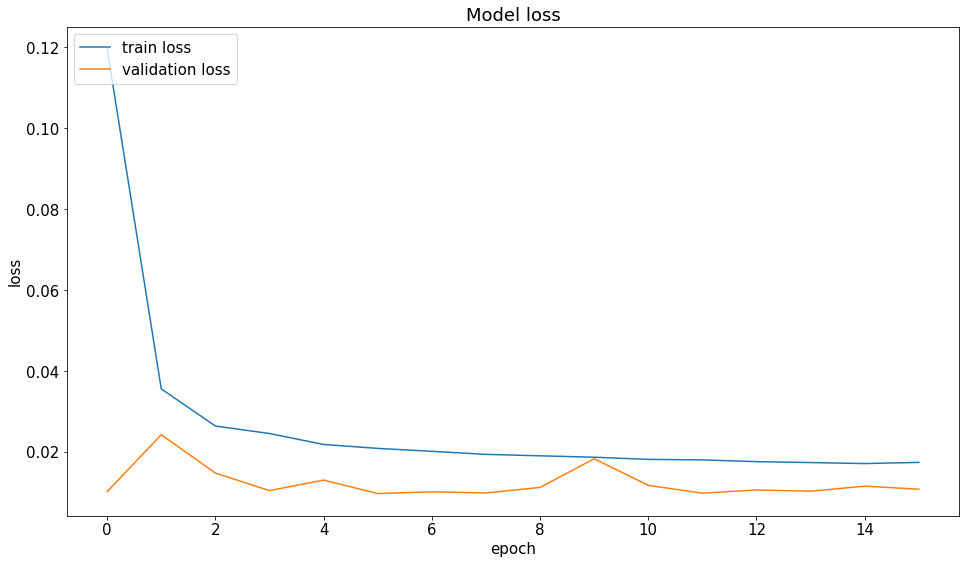

In [174]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [175]:
#data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))

data_val = x_scaler.fit_transform(df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100))
#original
#data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(80))

In [176]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [177]:
Predicted_results = Trained_model.predict(val_rescaled)

In [178]:
Predicted_results

array([[0.7372553 , 0.7174958 , 0.7132242 , 0.7170415 , 0.7063302 ,
        0.7005482 , 0.706396  , 0.70722383, 0.7053958 , 0.72814375,
        0.71653986, 0.7274902 , 0.7173252 , 0.71448094, 0.71153593,
        0.7104228 , 0.7262914 , 0.71784747, 0.7323095 , 0.71946764,
        0.72374195, 0.7232058 , 0.7347848 , 0.72090197, 0.7173057 ,
        0.71656865, 0.7083893 , 0.72223526, 0.7077765 , 0.719487  ,
        0.7261758 , 0.7230107 , 0.7169366 , 0.725945  , 0.7057399 ,
        0.7227694 , 0.70477706, 0.71215695, 0.7304638 , 0.7210559 ,
        0.6990509 , 0.709927  , 0.7089211 , 0.69459045, 0.7178108 ,
        0.71796864, 0.7317191 , 0.7086267 , 0.71161705, 0.71452045,
        0.714245  , 0.7332743 , 0.7073156 , 0.704126  , 0.72983944,
        0.70992064, 0.70905423, 0.7277726 , 0.7097249 , 0.69767404,
        0.71716785, 0.7093577 , 0.69057935, 0.721537  , 0.7284168 ,
        0.7203308 , 0.7206208 , 0.71183175, 0.72184426, 0.7224834 ,
        0.7104165 , 0.7038769 , 0.7268302 , 0.70

In [179]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [180]:
Predicted_results_Inv_trans

array([[692278.6 , 674905.8 , 671150.1 , 674506.4 , 665088.8 , 660005.2 ,
        665146.7 , 665874.5 , 664267.3 , 684267.6 , 674065.3 , 683693.  ,
        674755.8 , 672255.06, 669665.8 , 668687.1 , 682639.06, 675215.  ,
        687930.25, 676639.5 , 680397.5 , 679926.1 , 690106.56, 677900.56,
        674738.7 , 674090.6 , 666899.2 , 679072.8 , 666360.44, 676656.5 ,
        682537.4 , 679754.6 , 674414.1 , 682334.5 , 664569.8 , 679542.44,
        663723.3 , 670211.8 , 686307.5 , 678035.94, 658688.75, 668251.2 ,
        667366.75, 654767.06, 675182.75, 675321.56, 687411.1 , 667107.94,
        669737.1 , 672289.8 , 672047.7 , 688778.5 , 665955.25, 663150.9 ,
        685758.56, 668245.6 , 667483.8 , 683941.3 , 668073.5 , 657478.2 ,
        674617.44, 667750.6 , 651240.44, 678458.9 , 684507.75, 677398.4 ,
        677653.4 , 669925.9 , 678729.06, 679291.  , 668681.56, 662931.9 ,
        683112.75, 666261.44, 670018.3 , 685594.  , 664820.06, 672062.  ,
        680576.75, 668188.5 , 672032.7

In [181]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [182]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 10580241193.509892
MAE is : 91986.72775
RMSE is : 102860.29940414276
MAPE is : 13.841112428621596
R2 is : -0.398297972842081



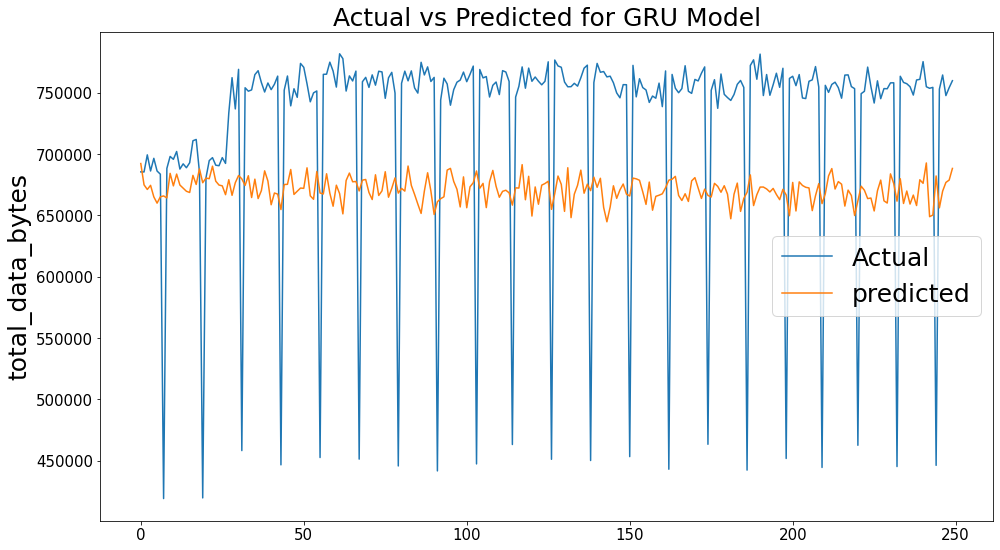

In [183]:


#plt.plot( list(validate['total_data_bytes']))
#plt.plot( list(Predicted_results_Inv_trans[0]))
#plt.title("Actual vs Predicted")
#plt.ylabel("total_data_bytes")
#plt.legend(('Actual','predicted'))
#plt.show()

plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.rcParams.update({'font.size': 15})
plt.title("Actual vs Predicted for GRU Model", fontsize=25)
plt.ylabel("total_data_bytes", fontsize=25)
plt.legend(('Actual','predicted'), fontsize=25)
#plt.legend(loc=5, prop={'size': 10})
###plt.rc('legend', fontsize='medium')
plt.show()
